

**Project Title:** Traffic Sign Classification

**Project Objective:**
To identify different traffic signs and accurately classify them into their respective predefined classes.

**Project Relevance:**
This project enhances road safety by enabling accurate, real-time recognition of traffic signs, thereby reducing human error and preventing accidents. It also plays a crucial role in the development of reliable driver assistance systems and autonomous vehicles by ensuring correct interpretation and compliance with traffic rules.

Specifications :

Dataset used : GTRSB https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Architecture: Convolutional Neural Network (CNN)
Framework used: TensorFlow with Keras
Model Evaluation Techniques used : confusion matrix and F1-score

In [2]:
#loading libraries
import os # file handling
import numpy as np #data handling
import pandas as pd #data handling
from PIL import Image # image loading
import matplotlib.pyplot as plt #visualization

# Libraries needed for data Preprocessing

import cv2 #image processing
from sklearn.model_selection import train_test_split #data splitting
from tensorflow.keras.utils import to_categorical #label encoding

import zipfile # file extraction

from tensorflow.keras.preprocessing.image import ImageDataGenerator #image augmentation and preprocessing






In [3]:
#Setting up the Kaggle environment for dataset download
from google.colab import files
files.upload()






Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adiyabeevis","key":"f071d83563f9b517d22dd228637ce331"}'}

In [4]:

import shutil

os.makedirs('/root/.config/kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.config/kaggle/kaggle.json')
os.chmod('/root/.config/kaggle/kaggle.json', 600)

**Downloading and Extracting the GTSRB Dataset**

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi  # imports kaggleapi class to programmatically interact with kaggle datasets

import zipfile  # imports zipfile module to handle zip-compressed files if needed

import os  # imports os module to interact with the operating system (create folders, manage paths)

# authenticate kaggle api
api = KaggleApi()  # creates an instance of the kaggle api client
api.authenticate()  # authenticates using kaggle.json credentials linked to your kaggle account

# create dataset directory
dataset_dir = "gtsrb_dataset"  # stores the directory name where the dataset will be saved locally
os.makedirs(dataset_dir, exist_ok=True)  # creates the directory if it does not exist and avoids errors if it already exists

# download dataset
api.dataset_download_files(  # calls kaggle api method to download all files from a dataset
    "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign",
    path=dataset_dir,
    unzip=True
)

print("GTSRB dataset downloaded and extracted successfully.")  # prints a confirmation message after successful download and extraction


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
GTSRB dataset downloaded and extracted successfully.


In [6]:

dataset_dir = "gtsrb_dataset" # Define dataset root directory
os.listdir(dataset_dir) # list contents of dataset directory

['Train',
 'Train.csv',
 'Meta',
 'Test.csv',
 'test',
 'train',
 'Test',
 'meta',
 'Meta.csv']

In [7]:

train_df = pd.read_csv(os.path.join(dataset_dir, "Train.csv")) # List contents of dataset directory

train_df.head() # Display first few rows


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [8]:

print("Total training samples:", len(train_df)) # no of samples
print("Number of classes:", train_df['ClassId'].nunique()) # no of unique classes
print(train_df.isnull().sum()) # checks for missing values


Total training samples: 39209
Number of classes: 43
Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


**Loading  and cleaning image**

In [9]:
IMG_HEIGHT = 32
IMG_WIDTH = 32

images = []
labels = []

for idx, row in train_df.iterrows():
    try:
        img_path = os.path.join(dataset_dir, row['Path'])
        image = Image.open(img_path)
        image = image.resize((IMG_WIDTH, IMG_HEIGHT))
        image = np.array(image)

        images.append(image)
        labels.append(row['ClassId'])

    except Exception as e:

        continue # skip corrupted or unreadable images

images = np.array(images)
labels = np.array(labels)

print("Images loaded:", images.shape)
print("Labels loaded:", labels.shape)

Images loaded: (39209, 32, 32, 3)
Labels loaded: (39209,)


**Normalization & Label Encoding**

Normalize image pixel values for stable CNN training

Convert class labels into a format suitable for multi-class classification

In [10]:
# Normalize image pixel values from [0, 255] to [0, 1]
images = images / 255.0

# Convert class labels to categorical (one-hot encoding)
num_classes = train_df['ClassId'].nunique()
labels_encoded = to_categorical(labels, num_classes)

print("Normalized images shape:", images.shape)
print("Encoded labels shape:", labels_encoded.shape)

Normalized images shape: (39209, 32, 32, 3)
Encoded labels shape: (39209, 43)


Train–Validation Split

In [11]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels_encoded,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)



Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)
Training labels shape: (31367, 43)
Validation labels shape: (7842, 43)


**Data Augmentation**

Increase dataset diversity artificially

Improve model robustness to variations such as rotation, shifting, and zoom

Reduce overfitting by exposing the model to altered versions of training images

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,        # Randomly rotate images
    width_shift_range=0.1,    # Random horizontal shifts
    height_shift_range=0.1,   # Random vertical shifts
    zoom_range=0.1,           # Random zoom
    shear_range=0.1           # Shear transformations
)

# Validation data should NOT be augmented
val_datagen = ImageDataGenerator()

# Fit the generator on training data
train_datagen.fit(X_train)

**Build the CNN Model**

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize a sequential CNN model
model = Sequential()

#Convolutional Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Feature Maps
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Reduce overfitting

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Model Compilation**

In [14]:
from tensorflow.keras.optimizers import Adam

# Compile the CNN model
model.compile(
    optimizer=Adam(learning_rate=0.001),   # Adaptive optimizer for faster convergence
    loss='categorical_crossentropy',        # Suitable for multi-class classification
    metrics=['accuracy']                    # Track classification accuracy
)

print("Model compiled successfully.")

Model compiled successfully.


**Model Training**

Train the CNN using augmented training data

Validate performance on unseen validation data

Observe learning behaviour (accuracy and loss)

In [15]:
EPOCHS = 15  # no of complete passes over the training dataset

BATCH_SIZE = 64  # no of samples processed before updating model weights

history = model.fit(  # trains the model and stores training history (loss and accuracy)
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),  # generates augmented training batches
    steps_per_epoch=len(X_train) // BATCH_SIZE,  # no of batches processed in one epoch
    epochs=EPOCHS,  # total no of training epochs
    validation_data=(X_val, y_val)  # evaluates model performance on unseen validation data

)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


490/490 ━━━━━━━━━━━━━━━━━━━━ 71s 139ms/step - accuracy: 0.1827 - loss: 2.9982 - val_accuracy: 0.6433 - val_loss: 1.0886
Epoch 2/15
  1/490 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.4844 - loss: 1.3183

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4844 - loss: 1.3183 - val_accuracy: 0.6502 - val_loss: 1.0775
Epoch 3/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 94s 176ms/step - accuracy: 0.6112 - loss: 1.1925 - val_accuracy: 0.8670 - val_loss: 0.4166
Epoch 4/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6719 - loss: 0.8770 - val_accuracy: 0.8583 - val_loss: 0.4318
Epoch 5/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 85s 173ms/step - accuracy: 0.7919 - loss: 0.6516 - val_accuracy: 0.9288 - val_loss: 0.2403
Epoch 6/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8750 - loss: 0.3774 - val_accuracy: 0.9329 - val_loss: 0.2356
Epoch 7/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 75s 152ms/step - accuracy: 0.8683 - loss: 0.4182 - val_accuracy: 0.9677 - val_loss: 0.1176
Epoch 8/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8594 - loss: 0.3804 - val_accuracy: 0.9674 - val_loss: 0.1228
Epoch 9/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 63s 129ms/step - accuracy: 0.9037 - loss: 0.3091 - val_accuracy:

**Model Evaluation**

In [16]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)  # evaluates model on validation data
print(f"Validation Loss: {val_loss:.4f}")  # prints validation loss
print(f"Validation Accuracy: {val_accuracy:.4f}")  # prints validation accuracy


Validation Loss: 0.0747
Validation Accuracy: 0.9759


**Analyze Model Behavior**

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


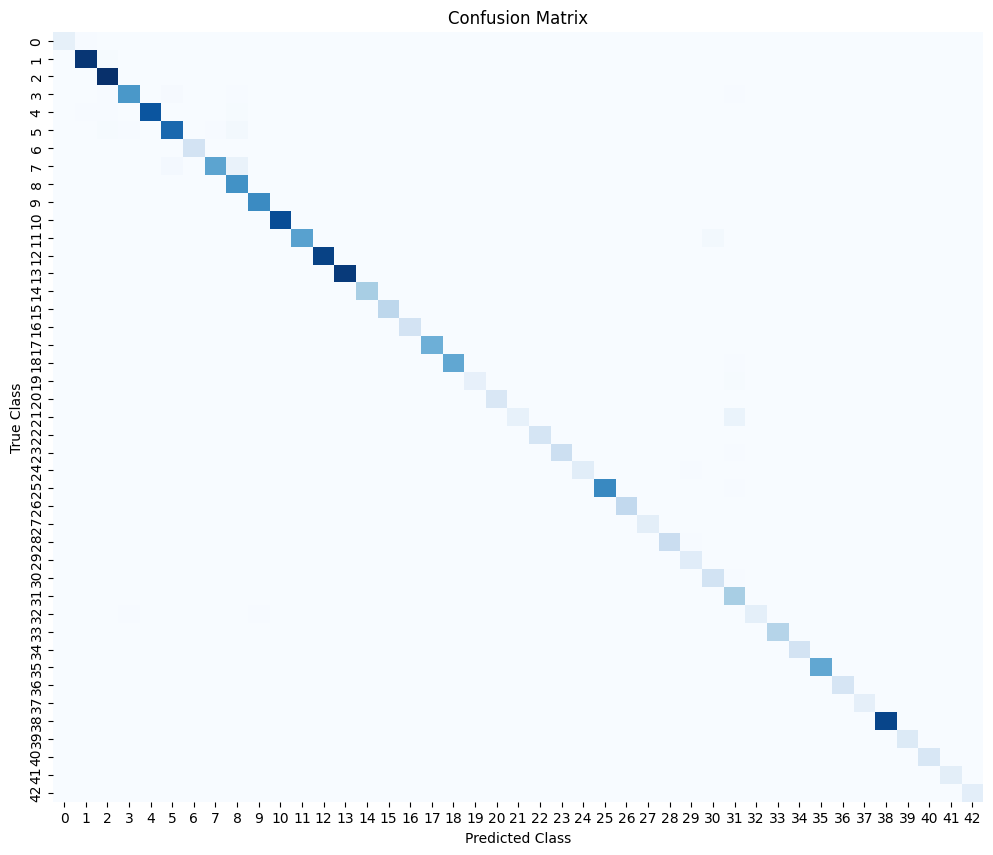

In [17]:
from sklearn.metrics import confusion_matrix  # imports function to compute confusion matrix

import seaborn as sns  # imports seaborn for statistical data visualization

y_pred = model.predict(X_val)  # generates prediction probabilities for validation data
y_pred_classes = np.argmax(y_pred, axis=1)  # converts predicted probabilities to class labels
y_true_classes = np.argmax(y_val, axis=1)  # converts one-hot encoded true labels to class labels
cm = confusion_matrix(y_true_classes, y_pred_classes)  # computes confusion matrix
plt.figure(figsize=(12, 10))  # sets the size of the plot
sns.heatmap(cm, cmap="Blues", cbar=False)  # visualizes confusion matrix as a heatmap
plt.xlabel("Predicted Class")  # labels x-axis as predicted classes
plt.ylabel("True Class")  # labels y-axis as true classes
plt.title("Confusion Matrix")  # sets plot title
plt.show()  # displays the plot


**Save the Model**

In [18]:
model.save("traffic_sign_classifier.h5")
print("Model saved as traffic_sign_classifier.h5")

Model saved as traffic_sign_classifier.h5


In [19]:
from tensorflow.keras.models import load_model

loaded_model = load_model("traffic_sign_classifier.h5")  # loads the trained cnn model from the saved file

**Define Class Name Mapping**

In [20]:
# mapping class indices to human-readable traffic sign labels
gtsrb_class_names = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}


**Model Test**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


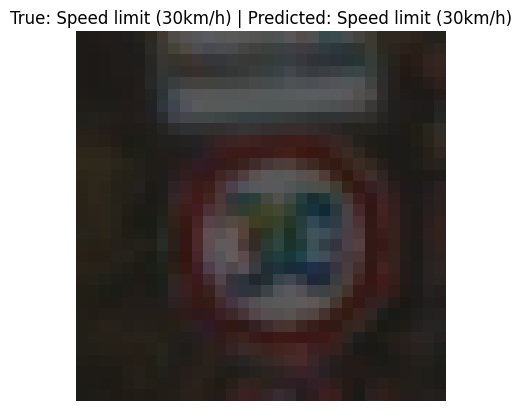

In [23]:
idx = np.random.randint(0, len(X_val))  # selects a random index from validation data
image = X_val[idx]  # retrieves the corresponding validation image

image_input = np.expand_dims(image, axis=0)  # adds batch dimension to match model input shape

prediction = loaded_model.predict(image_input)  # generates prediction for the selected image
predicted_class_id = np.argmax(prediction)  # extracts predicted class index
predicted_sign_name = gtsrb_class_names[predicted_class_id]  # maps predicted class index to sign name

true_sign_name = gtsrb_class_names[np.argmax(y_val[idx])]  # maps true class index to sign name
plt.imshow(image)  # displays the selected image

plt.axis("off")  # hides axis ticks for cleaner visualization
plt.title(f"True: {true_sign_name} | Predicted: {predicted_sign_name}")  # shows true vs predicted label
plt.show()  # renders the image plot


**Conclusion**

In this project, a convolutional neural network (cnn) was successfully designed, trained, and evaluated for german traffic sign recognition using the gtsrb dataset. Data preprocessing and image augmentation were applied to improve generalization and reduce overfitting, enabling the model to handle real-world variations such as rotation, lighting changes, and scale differences.

The trained model demonstrated strong performance on validation data, supported by accuracy metrics, loss values, and confusion matrix analysis. Random image inference confirmed that the model correctly predicts traffic sign classes and maps them to human-readable labels, proving the effectiveness of the end-to-end pipeline from data input to final prediction.
